**Description:** A prototype dashboard for identifying table columns from with issues.  This version focuses on ComCom data, but should be useful for LSSTcam commissioning data processing as well.

See Jira issue <a href=https://rubinobs.atlassian.net/browse/SP-861>SP-861</a>.



In [1]:

## 1.1 User-defined values

instrument = 'LSSTCam'
collectionName = 'LSSTCam/runs/DRP/20250501_20250609/w_2025_26/DM-51580'
table_type = 'objectTable' # currently, just 'objectTable' is recognized.  'sourceTable' is in the process of being implemented.
#table_type = 'sourceTable' # currently, just 'objectTable' is recognized.  'sourceTable' (or possibly 'recalibrated_star') is in the process of being implemented.

# Use downloaded CSV files ("True") or query the EFD ("False"):
useCSV = True

if useCSV:
    if instrument == 'LSSTComCam':
        tableSummaryDir = '../../../SP-861/pipe_tasks/LSSTComCam'
    elif instrument == 'LSSTCam':
        tableSummaryDir = '../../../SP-861/pipe_tasks/LSSTCam'
else:
    efd_name = 'usdfdev_efd'
    db_name = 'lsst.dm'
    table_name = """lsst.dm.%s""" % (table_type)
    time_lo = '2025-04-08'
    time_hi = '2025-12-31'
    
# Verbosity level:  0, 1, 2, 3...  higher values yield more output to screen
verbose = 2

In [2]:

## 1.2 Import packages

# Generic python packages
import os
import glob
import pickle
import numpy as np
import pandas as pd
import warnings
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import re # Import the regular expression module
from IPython.display import display

# Astropy-related packages
from astropy.time import Time

# LSST packages
from lsst_efd_client import EfdClient
import lsst.daf.butler as dafButler
from lsst.resources import ResourcePath

# Converts matplotlib.category INFO messages to WARNINGS
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

# Set filter warnings to "ignore" to avoid a lot of "logorrhea" to the screen:
warnings.filterwarnings("ignore")

# Set pandas to show all rows...
pd.set_option("display.max_rows", None)

In [3]:

# 1.3. Define methods and classes...

# Define a class to stop "Run All" at a code cell containing the command "raise StopExecution":
class StopExecution(Exception):
    def _render_traceback_(self):
        pass



def create_tract_markup_color_dict(repo, collection, skymap_name, top_n=20, plot=False):
    """
    Query LSSTCam science exposures, determine tract IDs, and return:
      - tract_dict_top: dict mapping tractId -> most frequent target_name (restricted to top targets)
      - marker_dict_top: dict mapping target_name -> matplotlib marker symbol
      - color_dict_top: dict mapping target_name -> matplotlib color

    Optionally plots the sky distribution of the top targets using Astropy for coordinate handling.

    Parameters
    ----------
    repo : str
        Butler repository path (e.g., '/repo/main')
    collection : str
        Butler collection name (e.g., 'LSSTCam/defaults')
    skymap_name : str
        Name of the skymap to load (e.g., 'lsst_cells_v1')
    top_n : int, optional
        Number of top target_names to consider (default=20)
    plot : bool, optional
        If True, produce a matplotlib Aitoff sky plot

    Returns
    -------
    tract_dict_top : dict
    marker_dict_top : dict
    color_dict_top : dict
    """

    # --- Step 0: Important necessary packages ---
    import matplotlib.pyplot as plt
    import numpy as np
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    from lsst.rsp import get_tap_service
    import lsst.daf.butler as dafButler
    from lsst.geom import SpherePoint, degrees

    # --- Step 1: Query ConsDB ---
    cdb = get_tap_service("consdbtap")
    assert cdb is not None, "Could not connect to consdbtap service."

    query = """SELECT img_type, science_program, target_name, scheduler_note, 
                      s_ra, s_dec, band, exp_midpt, exp_midpt_mjd, exp_time, can_see_sky 
               FROM cdb_lsstcam.visit1 
               WHERE img_type='science' AND can_see_sky='True'"""
    results = cdb.search(query).to_table()
    df_sci_exp = results.to_pandas()

    # Normalize empty target_name values
    df_sci_exp['target_name'] = (
        df_sci_exp['target_name']
        .replace('', np.nan)
        .fillna('<blank>')
    )

    # --- Step 2: Load skymap ---
    butler = dafButler.Butler(repo, collections=collection)
    skyMap = butler.get('skyMap', skymap=skymap_name)

    # --- Step 3: Add tractId ---
    def get_tract_id(row):
        try:
            coord = SpherePoint(row['s_ra'], row['s_dec'], degrees)
            tractInfo = skyMap.findTract(coord)
            return tractInfo.getId()
        except Exception:
            return None

    df_sci_exp['tractId'] = df_sci_exp.apply(get_tract_id, axis=1)

    # --- Step 4: Top N targets ---
    top_targets = (
        df_sci_exp['target_name']
        .value_counts()
        .head(top_n)
        .index
        .tolist()
    )

    df_sci_exp_top = df_sci_exp[df_sci_exp['target_name'].isin(top_targets)]

    # --- Step 5: tract_dict_top ---
    counts = df_sci_exp_top.groupby(['tractId', 'target_name']).size().reset_index(name='count')
    tract_dict_top = (
        counts.sort_values(['tractId', 'count'], ascending=[True, False])
              .drop_duplicates(subset='tractId')
              .set_index('tractId')['target_name']
              .to_dict()
    )

    # --- Step 6: Count unique tracts per target_name ---
    tract_counts = (
        df_sci_exp.groupby('target_name')['tractId']
        .nunique()
        .to_dict()
    )

    # --- Step 7: Sort top targets by tract count ---
    legend_order = sorted(top_targets, key=lambda t: tract_counts.get(t, 0), reverse=True)

    # --- Step 8: Assign markers/colors in sorted order ---
    marker_styles = ['o', 's', '^', 'v', '<', '>', 'D', 'p', '*', 'h', 'H', 'X', 'd', '|', '_', '+', 'x', 'P', '1', '2']
    color_cycle = plt.cm.tab20.colors

    marker_dict_top = {t: marker_styles[i % len(marker_styles)] for i, t in enumerate(legend_order)}
    color_dict_top = {t: color_cycle[i % len(color_cycle)] for i, t in enumerate(legend_order)}

    print

    # Add "Other" category
    marker_dict_top["Other"] = '.'
    color_dict_top["Other"] = 'lightgray'

    # Does not seem to be working:
    ## Add "All" category
    #marker_dict_top["All"] = '.'
    #color_dict_top["All"] = 'darkgray'

    # --- Step 9: Optional plotting ---
    if plot:
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111, projection="aitoff")
        ax.grid(True)

        # Plot top targets in sorted order
        for target in legend_order:
            subset = df_sci_exp[df_sci_exp['target_name'] == target]
            coords = SkyCoord(ra=subset['s_ra'].values * u.deg,
                              dec=subset['s_dec'].values * u.deg,
                              frame='icrs')
            # Wrap RA and flip for Rubin convention
            ra_rad = -coords.ra.wrap_at(180 * u.deg).radian
            dec_rad = coords.dec.radian

            ax.scatter(
                ra_rad,
                dec_rad,
                marker=marker_dict_top[target],
                color=color_dict_top[target],
                label=f"{target} ({tract_counts.get(target, 0)} tracts)",
                alpha=0.7,
                s=20
            )

        # Plot "Other" targets last
        subset_other = df_sci_exp[~df_sci_exp['target_name'].isin(top_targets)]
        if not subset_other.empty:
            coords = SkyCoord(ra=subset_other['s_ra'].values * u.deg,
                              dec=subset_other['s_dec'].values * u.deg,
                              frame='icrs')
            ra_rad = -coords.ra.wrap_at(180 * u.deg).radian
            dec_rad = coords.dec.radian

            other_tracts = subset_other['tractId'].nunique()

            ax.scatter(
                ra_rad,
                dec_rad,
                marker=marker_dict_top["Other"],
                color=color_dict_top["Other"],
                label=f"Other ({other_tracts} tracts)",
                alpha=0.5,
                s=10
            )

        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize='small')
        ax.set_title(f"Top {top_n} LSSTCam Science Fields in ConsDB by Tract", pad=20)
        plt.show()

    return tract_dict_top, marker_dict_top, color_dict_top


def instrument_create_tract_markup_color_dict(instrument):

    if instrument == 'LSSTComCam':
        
        # From Slide 9 of https://docs.google.com/presentation/d/1NGzrT4t6wDGQ2-2a8rjioToquhx2vOP_KJTrPiCrDDY/edit#slide=id.g33de3f5c849_6_250
        tract_dict={453: '47 Tuc', 
                    454: '47 Tuc',
                   4849: 'ECDFS', 
                   5063: 'ECDFS',
                   4848: 'ECDFS', 
                   2394: 'EDFS', 
                   2234: 'EDFS',
                   4016: 'Fornax', 
                   4017: 'Fornax', 
                   4218: 'Fornax', 
                   4217: 'Fornax', 
                   5525: 'Rubin_SV_095-25', 
                   5526: 'Rubin_SV_095-25', 
                   7611: 'Seagull', 
                   7610: 'Seagull', 
                   7850: 'Seagull',
                   10463: 'Rubin_SV_38_7', 
                   10464: 'Rubin_SV_38_7', 
                   10704: 'Rubin_SV_38_7'
                   }

        marker_dict={'47 Tuc': 'o', 
                     'ECDFS': 'v', 
                     'EDFS': '^', 
                     'Fornax': 's', 
                     'Rubin_SV_095-25': '*', 
                     'Seagull': 'd', 
                     'Rubin_SV_38_7': 'P', 
                     'Other': 'X'
                    }

        color_dict= {'47 Tuc': 'b', 
                     'ECDFS': 'g', 
                     'EDFS': 'r', 
                     'Fornax': 'c', 
                     'Rubin_SV_095-25': 'm', 
                     'Seagull': 'y', 
                     'Rubin_SV_38_7': 'k', 
                     'Other': 'gray'
                    }

    elif instrument == 'LSSTCam':
    
        try:

            # Try to grab from the ConsDB

            tract_dict, marker_dict, color_dict = create_tract_markup_color_dict(
                repo='/repo/main',
                collection='LSSTCam/defaults',
                skymap_name='lsst_cells_v1',
                top_n=20,
                plot=False   # Set to True if you want an Aitoff pojection plot of the top_n targets
            )

        except:
        
            # If not, here is an outdated list the Times Square TargetViewer
   
            tract_dict={9813 : 'COSMOS', 
                        1291 : 'Carina',
                        1292 : 'Carina',
                        1293 : 'Carina',
                        1417 : 'Carina',
                        9591 : 'DESI_SV3_R1',
                        9348 : 'DESI_SV3_R1',
                        10804 : 'M49',
                        10321 : 'M49',
                        10563 : 'M49',
                        10562 : 'M49',
                        10320 : 'M49',
                        10803 : 'M49',
                        6325: 'New_Horizons', 
                        6324: 'New_Horizons', 
                        6096: 'New_Horizons', 
                        6323: 'New_Horizons', 
                        6555: 'New_Horizons', 
                        6554: 'New_Horizons', 
                        3361: 'Prawn',
                        3360: 'Prawn',
                        3359: 'Prawn',
                        3362: 'Prawn',
                        3176: 'Prawn',
                        3175: 'Prawn',
                        8401:  'Rubin_SV_212_-7',
                        8400:  'Rubin_SV_212_-7',
                        8399:  'Rubin_SV_212_-7',
                        8641:  'Rubin_SV_212_-7',
                        8158:  'Rubin_SV_212_-7',
                        8883:  'Rubin_SV_212_-7',
                        6740:  'Rubin_SV_216_-17',
                        6973:  'Rubin_SV_216_-17',
                        3533:  'Rubin_SV_225_-40',
                        3534:  'Rubin_SV_225_-40',
                        3725:  'Rubin_SV_225_-40',
                        3346:  'Rubin_SV_225_-40',
                        3724:  'Rubin_SV_225_-40',
                        3345:  'Rubin_SV_225_-40',
                        3532:  'Rubin_SV_225_-40',
                        5857:  'Trifid-Lagoon',
                        5636:  'Trifid-Lagoon',
                        5635:  'Trifid-Lagoon',
                        5634:  'Trifid-Lagoon',
                        5858:  'Trifid-Lagoon',
                        1189:  'Alpha_Centauri',
                        1312:  'Alpha_Centauri',
                        1438:  'Alpha_Centauri',
                        1439:  'Alpha_Centauri_at_the_edge'
                       }

            marker_dict={'COSMOS': 'o', 
                         'Carina': 'v', 
                         'DESI_SV3_R1': '^', 
                         'M49': 's', 
                         'New_Horizons': '*', 
                         'Prawn': 'd', 
                         'Rubin_SV_212_-7': 'P',
                         'Rubin_SV_216_-17': '<', 
                         'Rubin_SV_225_-40': '>', 
                         'Trifid-Lagoon': '8', 
                         'Alpha_Centauri': 'h', 
                         'Alpha_Centauri_at_the_edge': 'H', 
                         'Other': 'X'
                        }

            color_dict= {'COSMOS': 'b', 
                         'Carina': 'g', 
                         'DESI_SV3_R1': 'r', 
                         'M49': 'c', 
                         'New_Horizons': 'm', 
                         'Prawn': 'pink', 
                         'Rubin_SV_212_-7': 'k', 
                         'Rubin_SV_216_-17': 'c', 
                         'Rubin_SV_225_-40': 'aquamarine', 
                         'Trifid-Lagoon': 'powderblue', 
                         'Alpha_Centauri': 'violet', 
                         'Alpha_Centauri_at_the_edge': 'darkviolet',              
                         'Other': 'gray'
                        }

        return tract_dict, marker_dict, color_dict



In [4]:

# 1.3. (cont'd)  Define (yet more) methods and classes... 

# Developed using ChatGPT-5 on Microsoft Copilot:
def plot_hist_and_scatter(
    df, numeric_cols, filtername, table_type, collectionName,
    marker_dict, color_dict, super_title,
    output_file=None, show_inline=False,
    base_row_height=None, max_height=None
):
    """
    Create histogram + scatter plots for given numeric columns, with auto figure height.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data.
    numeric_cols : list
        List of numeric column names to plot.
    filtername : str
        Filter name (e.g., 'g', 'none', 'all') for labeling.
    table_type : str
        'objectTable' or 'sourceTable'.
    collectionName : str
        Name of the collection for titles.
    marker_dict, color_dict : dict
        Dictionaries mapping fieldnames to markers/colors.
    super_title : str
        Figure suptitle.
    output_file : str or None
        If provided, save figure to this file.
    show_inline : bool
        If True, display the plot in the notebook.
    base_row_height : int or float or None
        Height (in inches) per numeric column row. If None, chosen automatically:
        - Larger for saved plots
        - Smaller for previews
    max_height : int or float or None
        Maximum figure height in inches. If None, chosen automatically:
        - Larger for saved plots
        - Smaller for previews
    """
    n_cols = len(numeric_cols)
    global_min, global_max = -0.1, 1.1

    # Auto-choose sizing defaults if not provided
    if output_file:  # full saved plot
        if base_row_height is None:
            base_row_height = 4     # compact but readable
        if max_height is None:
            max_height = 250        # allow very tall figures
    else:  # preview
        if base_row_height is None:
            base_row_height = 4     # compact but readable
        if max_height is None:
            max_height = 40         # cap for notebook display

    # Auto-adjust figure height
    fig_height = min(base_row_height * n_cols, max_height)

    fig, axes = plt.subplots(n_cols, 2, figsize=(12, fig_height), sharex=False)
    plt.subplots_adjust(top=0.98, bottom=0.05, hspace=0.25, wspace=0.3)

    # Ensure axes is always 2D array for consistent indexing
    if n_cols == 1:
        axes = np.array([axes])

    for i, col in enumerate(numeric_cols):
        ax_hist = axes[i, 0]
        data = df[col].dropna()
        # TEMPORARUY KLUDGE!!!:  Remove tracts for which the NaN_Fraction >= 1.00 for this col
        data = data[data < 1.00]
        if data.empty:
            continue

        # Stats
        data_desc = data.describe(percentiles=[0.01, 0.99])
        mean = data_desc['mean']
        std = data_desc['std']
        percent_01 = data_desc['1%']
        median = data_desc['50%']
        percent_99 = data_desc['99%']

        # Histogram
        ax_hist.hist(data, bins=50, alpha=0.75, range=(global_min, global_max))
        xlabel = col.replace("_nan_fraction", "")
        if table_type == 'objectTable':
            xlabel = f"NaN Fraction in tract:    {xlabel}"
            ax_hist.set_ylabel('N_tracts')
        elif table_type == 'sourceTable':
            xlabel = f"NaN Fraction in visit:    {xlabel}"
            ax_hist.set_ylabel('N_visits')
        ax_hist.set_xlabel(xlabel)
        ax_hist.grid(True, alpha=0.3)
        ax_hist.axvline(mean, color='r', linestyle='--', alpha=0.8, label=f'Mean: {mean:.2f}')
        ax_hist.axvline(percent_01, color='b', linestyle='--', alpha=0.8, label=f'1%: {percent_01:.2f}')
        ax_hist.axvline(median, color='orange', linestyle='--', alpha=0.8, label=f'50%: {median:.2f}')
        ax_hist.axvline(percent_99, color='g', linestyle='--', alpha=0.8, label=f'99%: {percent_99:.2f}')
        stats_text = f'N: {len(data)}\nσ: {std:.2f}'
        ax_hist.text(0.10, 0.95, stats_text,
                     transform=ax_hist.transAxes,
                     verticalalignment='top',
                     horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax_hist.legend()

        # Scatter
        ax_scatter = axes[i, 1]
        for fieldname in df['fieldname'].unique():
            subset = df[df['fieldname'] == fieldname]
            marker = marker_dict[fieldname]
            color = color_dict[fieldname]
            if table_type == 'objectTable':
                ax_scatter.scatter(subset[col], subset['tract'],
                                   marker=marker, color=color, label=fieldname, alpha=0.7)
                ax_scatter.set_ylabel('Tract')
            elif table_type == 'sourceTable':
                ax_scatter.scatter(subset[col], subset['visit'],
                                   marker=marker, color=color, label=fieldname, alpha=0.7)
                ax_scatter.set_ylabel('Visit')
        ax_scatter.set_xlabel(xlabel)
        ax_scatter.grid(True, alpha=0.3)
        ax_scatter.legend(title='Fieldname', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xlim(global_min, global_max)
    plt.suptitle(super_title, y=1.001, size=14, weight='bold')
    plt.tight_layout()

    if output_file:
        fig.savefig(output_file, dpi=150, bbox_inches='tight')
        plt.close(fig)
        print(f"Generated plot with {n_cols} rows (numeric columns) → saved to: {os.path.abspath(output_file)}")
    if show_inline:
        plt.show()
        if not output_file:
            print(f"Generated preview plot with {n_cols} rows (numeric columns) → displayed inline")


# Developed using ChatGPT-5 on Microsoft Copilot:

def plot_nan_fraction_summary(
    df, table_type, collectionName,
    output_file=None, show_inline=False,
    title_prefix="",
    max_height_per_row=0.25, base_height=4,
    reference_order=None,
    full_plot_path=None
):
    """
    Plot NaN fraction summary scatterplot for given DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns '1%', '50%', '99%' and 'name'.
    table_type : str
        'objectTable' or 'sourceTable'.
    collectionName : str
        Name of the collection for titles.
    output_file : str or None
        If provided, save figure to this file.
    show_inline : bool
        If True, display the plot in the notebook.
    title_prefix : str
        Optional prefix for the plot title.
    max_height_per_row : float
        Height in inches per row for sizing the figure.
    base_height : float
        Minimum figure height in inches.
    reference_order : list or None
        Optional list of index labels to enforce a specific row order.
    full_plot_path : str or None
        Optional addition of full path to the output file the super title.
    """
    # If a reference order is provided, reindex to match it (dropping missing)
    if reference_order is not None:
        df = df.loc[df.index.intersection(reference_order)]
        df = df.reindex(reference_order)

    n_rows = len(df)
    fig_height = max(base_height, n_rows * max_height_per_row)

    fig = plt.figure(figsize=(10, fig_height))
    plt.grid(True)

    ax = sns.scatterplot(data=df, x="1%", y="name", color='b', label="1%")
    sns.scatterplot(data=df, x="50%", y="name", ax=ax, color='orange', label="50%")
    sns.scatterplot(data=df, x="99%", y="name", ax=ax, color='g', label="99%")

    plt.legend(title="Percentiles")

    # Force correct x-axis label
    plt.xlabel("NaN Fraction")

    # Build title
    if table_type == 'objectTable':
        title_text = f"{title_prefix} NaN Fraction in Tract\nCollection: {collectionName}"
    elif table_type == 'sourceTable':
        title_text = f"{title_prefix} NaN Fraction in Visit\nCollection: {collectionName}"
    else:
        title_text = f"{title_prefix} NaN Fraction\nCollection: {collectionName}"

    # Append file path only for preview
    if output_file is None and full_plot_path:
        title_text += f"\nFull plot in {os.path.abspath(full_plot_path)}"

    plt.title(title_text)

    # Adjust margins
    plt.margins(y=0.0075 if n_rows > 10 else 0.1)
    plt.tight_layout()

    if output_file:
        fig.savefig(output_file, dpi=150, bbox_inches='tight')
        plt.close(fig)
        print(f"Generated plot with {n_rows} rows (numeric columns) → saved to: {os.path.abspath(output_file)}")
    if show_inline:
        plt.show()
        if not output_file:
            print(f"Generated preview plot with {n_rows} rows (numeric columns) → displayed inline")


In [5]:

# 2. Retrieve data

In [6]:

## 2.1. Retrieve data from CSV files

In [7]:

### 2.1.1.  Identify CSV files to read

if useCSV:
    
    if table_type == 'objectTable':
        pattern = os.path.join(tableSummaryDir, 'objectSummary.*.csv')
    elif table_type == 'sourceTable':
        pattern = os.path.join(tableSummaryDir, 'sourceSummary.*.csv')
    else:
        print("""%s is unrecognized...  Stopping here!""" % (table_type))
        raise StopExecution

    files = glob.glob(pattern)

    if verbose > 2:
        for f in files:
            print(f)


In [8]:

### 2.1.2.  Create pandas DataFrame that contains the data from all the CSV files

# Per Gemini+2.5-Flash:

if useCSV:
    
    # Create an empty list to store individual DataFrames
    all_dfs = []

    # Regular expression to find the tract or visit number
    # It looks for one or more digits (\d+) between "*Summary." and ".csv"
    if table_type == 'objectTable':
        tract_regex = re.compile(r'objectSummary\.(\d+)\.csv')
    elif table_type == 'sourceTable':
        visit_regex = re.compile(r'sourceSummary\.(\d+)\.csv')
    else:
        print("""%s is unrecognized...  Stopping here!""" % (table_type))
        raise StopExecution

    for file_path in files:
        try:
            # Read each CSV file into a DataFrame
            df_temp = pd.read_csv(file_path)

            # Extract the filename from the full path
            filename = os.path.basename(file_path)

            if table_type == 'objectTable':
                # Use regex to find the tract number
                match = tract_regex.match(filename)
                if match:
                    tract_number = int(match.group(1)) # Convert the extracted string to an integer
                    # Add the tract number as a new column to the temporary DataFrame
                    df_temp['tract'] = tract_number
                else:
                    print(f"Warning: Could not extract tract number from {filename}. 'tract' column for this file will be NaN.")
                    df_temp['tract'] = pd.NA # Assign a missing value if no tract is found
            elif table_type == 'sourceTable':
                # Use regex to find the tract number
                match = visit_regex.match(filename)
                if match:
                    visit_number = int(match.group(1)) # Convert the extracted string to an integer
                    # Add the tract number as a new column to the temporary DataFrame
                    df_temp['visit'] = visit_number
                else:
                    print(f"Warning: Could not extract visit number from {filename}. 'visit' column for this file will be NaN.")
                    df_temp['visit'] = pd.NA # Assign a missing value if no tract is found

            all_dfs.append(df_temp)

        except pd.errors.EmptyDataError:
            print(f"Warning: {file_path} is empty and will be skipped.")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    # Concatenate all DataFrames in the list into a single DataFrame
    if all_dfs:
        df = pd.concat(all_dfs, ignore_index=True)
        if verbose > 1:
            if table_type == 'objectTable':
                print(f"Successfully loaded {df['tract'].nunique()} of {len(files)} CSV files into a single DataFrame.")
            elif table_type == 'objectTable':
                print(f"Successfully loaded {df['visit'].nunique()} of {len(files)} CSV files into a single DataFrame.")
            else:
                print("Successfully loaded the CSV files into a single DataFrame.")
            print(f"Total rows in combined DataFrame: {len(df)}")
            #print(df['tract'].value_counts()) # Show the count of rows for each tract
    else:
        df = pd.DataFrame() # Create an empty DataFrame if no files were found or loaded
        if verbose > 0:
            print("No CSV files found or loaded to create a DataFrame.")


    # Check if 'Unnamed: 0' column exists and drop it
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
        if verbose > 1:
            print("Removed 'Unnamed: 0' column from the combined DataFrame.")

    if verbose > 1:
        display(df.head()) # Display the first few rows of the final DataFrame


Successfully loaded 141 of 141 CSV files into a single DataFrame.
Total rows in combined DataFrame: 119850
Removed 'Unnamed: 0' column from the combined DataFrame.


,percent_01,percent_50,percent_99,total_rows,nan_count,nan_fraction,colname,tract
0,7228.750,361437.50,715646.250,722876,0,0.0,index,10804
1,10804.000,10804.00,10804.000,722876,0,0.0,tract,10804
2,2.000,51.00,97.000,722876,0,0.0,patch,10804
3,186.764,187.52,188.236,722876,0,0.0,g_ra,10804
4,7.452,8.20,8.911,722876,0,0.0,g_dec,10804


In [9]:

### 2.1.3.  Create df_piv using pivot_table

# Per Gemini+2.5-Flash:

if useCSV:

    # Define the columns that will become values in the new DataFrame
    value_cols = [
        'percent_01', 'percent_50', 'percent_99',
        'total_rows', 'nan_count', 'nan_fraction'
    ]

    # Use pivot_table to reshape the DataFrame
    if table_type == 'objectTable':
        df_piv = df.pivot_table(
            index='tract',          # The column that will become the new index (one row per tract)
            columns='colname',      # The column whose unique values will become new columns
            values=value_cols       # The columns whose values will populate the new pivoted columns
        )
    elif table_type == 'sourceTable':
        df_piv = df.pivot_table(
            index='visit',          # The column that will become the new index (one row per tract)
            columns='colname',      # The column whose unique values will become new columns
            values=value_cols       # The columns whose values will populate the new pivoted columns
        )
    else:
        print("""%s is unrecognized...  Stopping here!""" % (table_type))
        raise StopExecution

    # After pivoting, the columns will be a MultiIndex (e.g., ('percent_01', 'ra')).
    # We need to flatten them to the desired format: <colname>_<metric>
    # The order is (metric, colname), so we need to swap levels and then join.

    # Swap the levels of the MultiIndex columns so 'colname' comes first
    df_piv.columns = df_piv.columns.swaplevel(0, 1)

    # Sort the columns for better readability (optional, but good practice)
    df_piv = df_piv.sort_index(axis=1)

    # Flatten the MultiIndex columns to a single level as '<colname>_<metric>'
    # This creates a new list of column names like 'ra_percent_01', 'ra_percent_50', etc.
    df_piv.columns = ['_'.join(col).strip() for col in df_piv.columns.values]

    # Reset the index to turn 'tract' from an index back into a regular column (optional)
    df_piv = df_piv.reset_index()

    # Rename df_piv as res
    res = df_piv

    if verbose > 1:
        print("\n--- Pivoted DataFrame (res(=df_piv)) ---")
        display(res.head())
        #print("\nNew res.columns:", res.columns.tolist())
        


--- Pivoted DataFrame (res(=df_piv)) ---


,tract,coord_dec_nan_count,coord_dec_nan_fraction,coord_dec_percent_01,coord_dec_percent_50,coord_dec_percent_99,coord_dec_total_rows,coord_decErr_nan_count,coord_decErr_nan_fraction,coord_decErr_percent_01,...,z_sersicFluxErr_percent_01,z_sersicFluxErr_percent_50,z_sersicFluxErr_percent_99,z_sersicFluxErr_total_rows,z_sizeExtendedness_nan_count,z_sizeExtendedness_nan_fraction,z_sizeExtendedness_percent_01,z_sizeExtendedness_percent_50,z_sizeExtendedness_percent_99,z_sizeExtendedness_total_rows
0,2982,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0
1,2983,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0
2,2995,0.0,0.0,-43.637,-43.277,-43.143,38704.0,798.0,0.021,0.0,...,NaN,NaN,NaN,38704.0,38704.0,1.0,NaN,NaN,NaN,38704.0
3,2996,0.0,0.0,-43.659,-43.391,-43.146,52660.0,1376.0,0.026,0.0,...,NaN,NaN,NaN,52660.0,52660.0,1.0,NaN,NaN,NaN,52660.0
4,2997,0.0,0.0,-43.436,-43.267,-43.143,60113.0,3451.0,0.057,0.0,...,NaN,NaN,NaN,60113.0,60113.0,1.0,NaN,NaN,NaN,60113.0


In [10]:

## Retrieve data from EFD

In [11]:

### 2.2.1. Prepare query

if not useCSV:
    query = '''SELECT * FROM "%s" WHERE  time > '%s' and time < '%s' ''' % (table_name, time_lo, time_hi)
    if verbose > 1:
        print(query)


In [12]:

# 2.2.2 Connect to EFD database and run query

if not useCSV:

    efd_client = EfdClient(efd_name, db_name=db_name)
    res = await efd_client.influx_client.query(query)

    if verbose > 0:
        print('Number of entries returned: ', len(res)) 
        if table_type == 'objectTable':
            print('Unique tracts returned:  ', len(res['tract'].unique()))
        elif table_type == 'sourceTable':
            print('Unique visits returned:  ', len(res['visit'].unique()))
        else:
            print("""%s is unrecognized...  Stopping here!""" % (table_type))
            raise StopExecution
        print('')

    if verbose > 1:
        display(res.head())

In [13]:

## 3.1 Get a list of column names that contain numeric data
numeric_columns = res.select_dtypes(include='number').columns.tolist()

# Display the numeric column names
if verbose > 2:
    print(numeric_columns)

In [14]:

## 3.2 Get a list of numeric columns with the suffix "_nan_fraction"
nan_fraction_columns = [
    col for col in res.select_dtypes(include='number').columns if col.endswith('_nan_fraction')
]

if table_type == 'objectTable':
    # Append 'tract' to the front of the list
    nan_fraction_columns = ['tract'] + nan_fraction_columns
elif table_type == 'sourceTable':
    # Append 'visit' to the front of the list
    nan_fraction_columns = ['visit'] + nan_fraction_columns
else:
    print("""%s is unrecognized...  Stopping here!""" % (table_type))
    raise StopExecution

# Display the filtered column names
if verbose > 2:
    print(nan_fraction_columns)

In [15]:

## 3.3 Create a new DataFrame with the selected columns
res_nan_fraction = res[nan_fraction_columns]

# Display the new DataFrame
if verbose > 0:
    display(res_nan_fraction.head())

,tract,coord_dec_nan_fraction,coord_decErr_nan_fraction,coord_ra_nan_fraction,coord_raErr_nan_fraction,coord_ra_dec_Cov_nan_fraction,deblend_iterations_nan_fraction,deblend_logL_nan_fraction,deblend_nChild_nan_fraction,deblend_nPeaks_nan_fraction,...,z_psfModel_TwoGaussian_gauss2_rho_nan_fraction,z_psfModel_TwoGaussian_gauss2_sigma_x_nan_fraction,z_psfModel_TwoGaussian_gauss2_sigma_y_nan_fraction,z_psfModel_TwoGaussian_n_iter_nan_fraction,z_ra_nan_fraction,z_raErr_nan_fraction,z_ra_dec_Cov_nan_fraction,z_sersicFlux_nan_fraction,z_sersicFluxErr_nan_fraction,z_sizeExtendedness_nan_fraction
0,2982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2995,0.0,0.021,0.0,0.021,0.021,0.0,0.714,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2996,0.0,0.026,0.0,0.026,0.026,0.0,0.804,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2997,0.0,0.057,0.0,0.057,0.057,0.0,0.827,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0



Processing filter: u
  Dropped 8 tracts with all-NaN values for filter 'u'
    Tracts dropped: [2982, 2983, 3739, 8156, 9327, 9328, 11283, 11284]
Generated plot with 132 rows (numeric columns) → saved to: /home/d/dltucker/WORK/GitHub/SP-861-patch-1/vv-team-notebooks/notebooks/NaN_Fraction_in_Tract_histograms_u.png
  Saved big plot to: /home/d/dltucker/WORK/GitHub/SP-861-patch-1/vv-team-notebooks/notebooks/NaN_Fraction_in_Tract_histograms_u.png


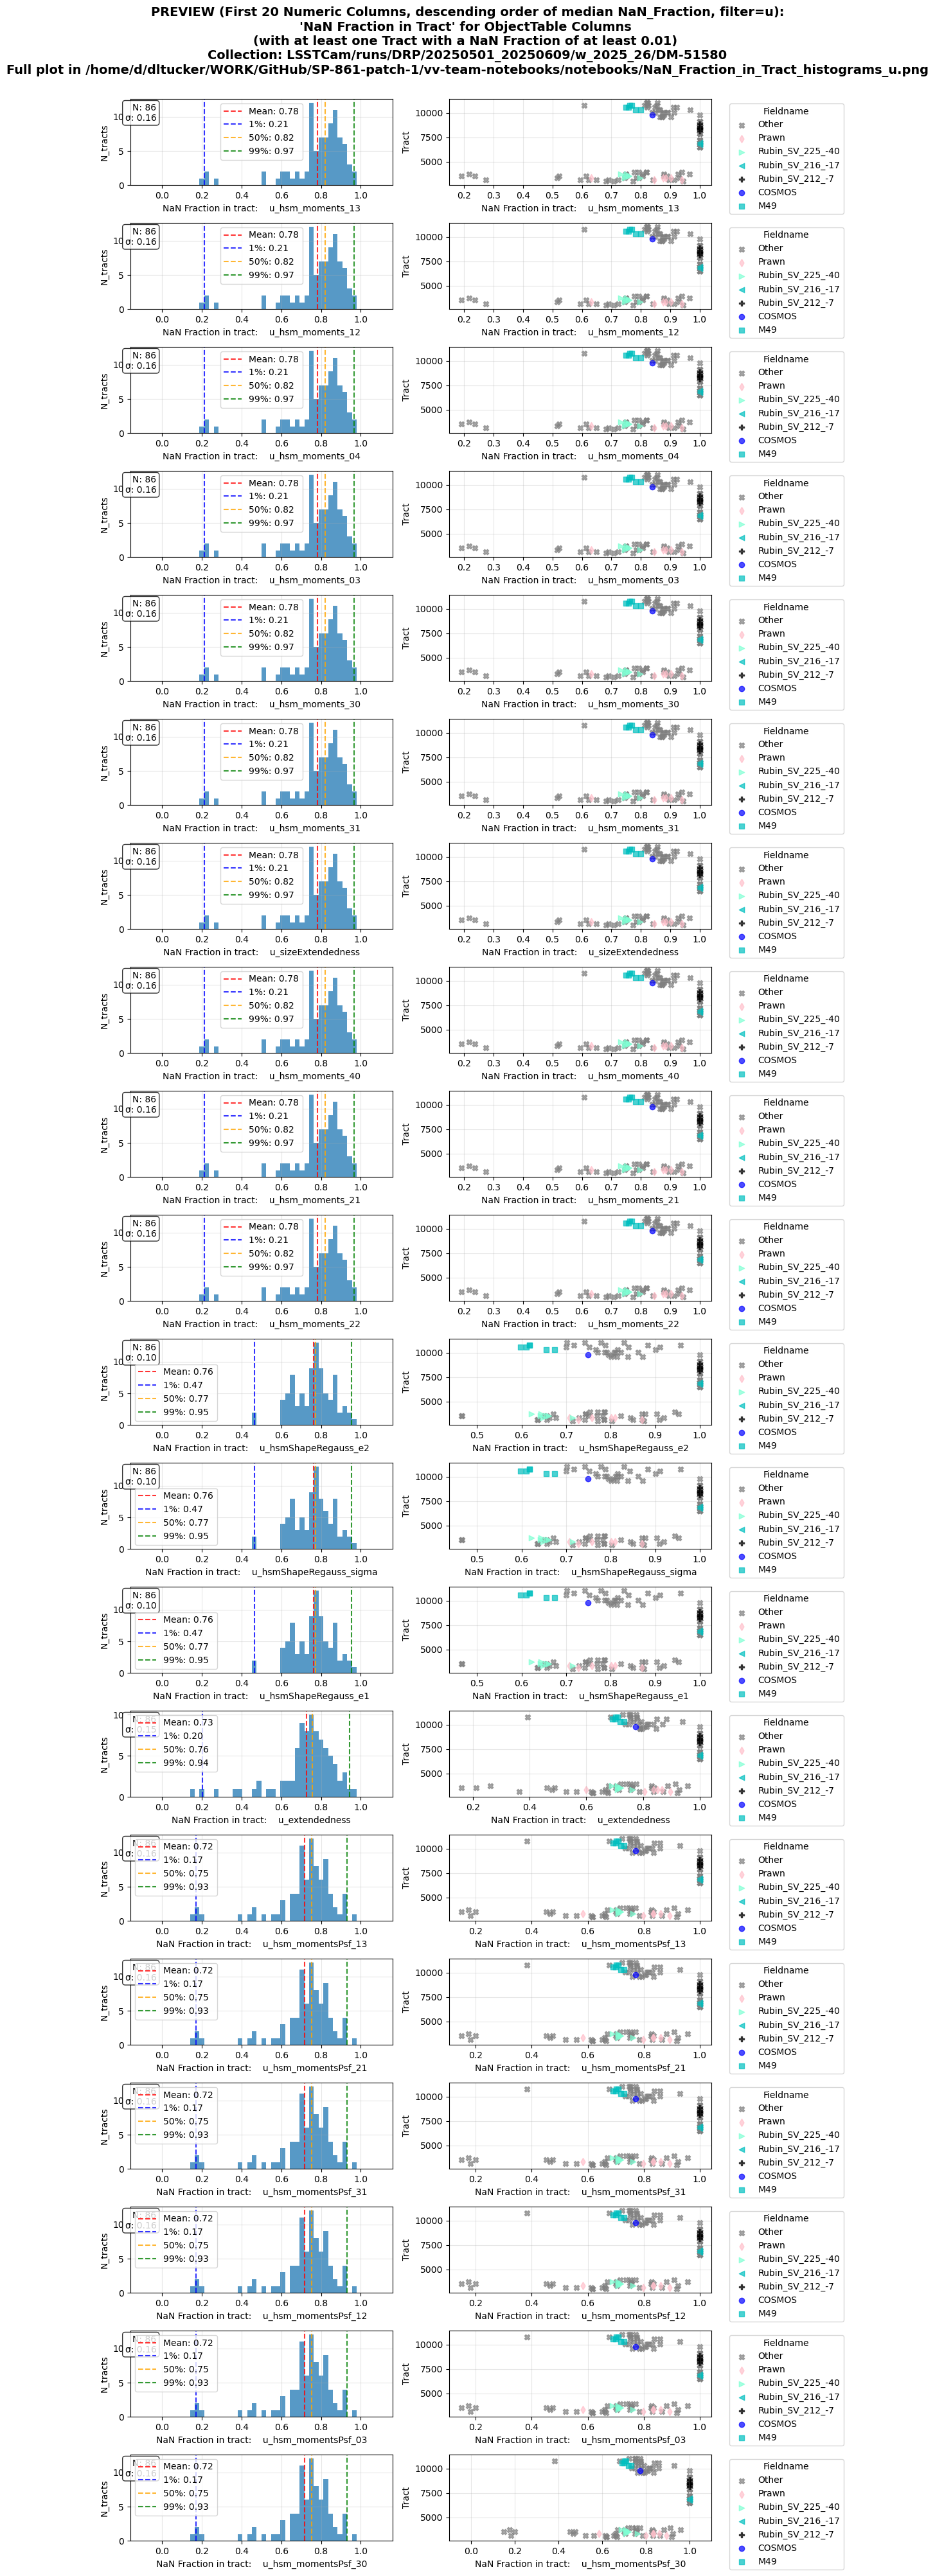

Generated preview plot with 20 rows (numeric columns) → displayed inline

Processing filter: g
  Dropped 8 tracts with all-NaN values for filter 'g'
    Tracts dropped: [2982, 2983, 3739, 8156, 9327, 9328, 11283, 11284]
Generated plot with 132 rows (numeric columns) → saved to: /home/d/dltucker/WORK/GitHub/SP-861-patch-1/vv-team-notebooks/notebooks/NaN_Fraction_in_Tract_histograms_g.png
  Saved big plot to: /home/d/dltucker/WORK/GitHub/SP-861-patch-1/vv-team-notebooks/notebooks/NaN_Fraction_in_Tract_histograms_g.png

Processing filter: r
  Dropped 8 tracts with all-NaN values for filter 'r'
    Tracts dropped: [2982, 2983, 3739, 8156, 9327, 9328, 11283, 11284]
Generated plot with 132 rows (numeric columns) → saved to: /home/d/dltucker/WORK/GitHub/SP-861-patch-1/vv-team-notebooks/notebooks/NaN_Fraction_in_Tract_histograms_r.png
  Saved big plot to: /home/d/dltucker/WORK/GitHub/SP-861-patch-1/vv-team-notebooks/notebooks/NaN_Fraction_in_Tract_histograms_r.png

Processing filter: i
  Dropp

In [16]:

## 3.4 Plot histograms of the 'NaN fraction in a Tract (or Visit)' 
## for all columns of res_nan_fraction that contain at least one tract (or visit) 
## with a NaN fraction > 0.01 for that column

df = res_nan_fraction.copy()

# Grab relevant tract, marker, and color dictionaries appropriate for the instrument
tract_dict, marker_dict, color_dict = instrument_create_tract_markup_color_dict(instrument)

# Create the 'fieldname' column using map and fillna
if table_type == 'objectTable':
    df['fieldname'] = df['tract'].astype(int).map(tract_dict).fillna('Other')
else:
    df['fieldname'] = 'Other'

# Reorder columns so 'fieldname' is second
cols = df.columns.tolist()
cols.insert(1, cols.pop(cols.index('fieldname')))
df = df[cols]

# Define filter list
if table_type == 'objectTable':
    filternameList = ['u', 'g', 'r', 'i', 'z', 'y', 'none']
    #filternameList = ['g']   # <-- for testing a single filter
else:
    filternameList = ['all']

# Get numeric columns
df_numeric = df.select_dtypes(include='number')

# Filter for columns with values > 0.01
cols_above_threshold = df_numeric.columns[(df_numeric > 0.01).any()]

# Container for summary stats
summary_records = []

# Plot Preview flag
plot_preview = True

# Loop over filters...
for filtername in filternameList:
    print(f"\nProcessing filter: {filtername}")

    if filtername in ('none', 'all'):
        numeric_cols = cols_above_threshold[~cols_above_threshold.str.match(r'^[ugrizy]_')]
    else:
        numeric_cols = cols_above_threshold[cols_above_threshold.str.match(f'^{filtername}_')]

    # --- CLEANING STEP ---
    ignored_special_cols = []
    dropped_tracts = []
    if table_type == 'objectTable' and filtername != 'all':
        filter_cols = list(numeric_cols)

        # Define the special columns to ignore
        special_cols = [
            f"{filtername}_psfModel_TwoGaussian_n_iter",
            f"{filtername}_inputCount"
        ]
        for sc in special_cols:
            if sc in filter_cols:
                filter_cols.remove(sc)
                ignored_special_cols.append(sc)

        if filter_cols:
            # Boolean mask: True if all filter_cols are NaN for that row
            mask_all_nan = df[filter_cols].isna().all(axis=1)
            dropped_count = mask_all_nan.sum()
            # Collect the tract IDs that were dropped
            dropped_tracts = df.loc[mask_all_nan, 'tract'].tolist()
            df_subset = df.loc[~mask_all_nan].copy()
            msg = f"  Dropped {dropped_count} tracts with all-NaN values for filter '{filtername}'"
            if ignored_special_cols:
                msg += f" (ignoring {', '.join(ignored_special_cols)})"
            if dropped_tracts:
                msg += f"\n    Tracts dropped: {dropped_tracts}"
            print(msg)
        else:
            df_subset = df.copy()
            dropped_count = 0
            dropped_tracts = []
            print(f"  No numeric columns (other than {', '.join(special_cols)}) found for filter '{filtername}'")
    else:
        df_subset = df.copy()
        dropped_count = 0
    # ---------------------

    # Compute medians for the candidate columns (on the cleaned subset)
    if len(numeric_cols) > 0:
        #median_vals = df_subset[numeric_cols].median()
        # TEMPORARY KLUDGE!!!:  Mask out values >= 1.0 so they don't affect the median
        median_vals = df_subset[numeric_cols].mask(df_subset[numeric_cols] >= 1.0).median()
        # Sort descending by median
        numeric_cols = median_vals.sort_values(ascending=False).index.tolist()
    else:
        print(f"  Skipping filter '{filtername}' (no numeric columns after cleaning)")
        summary_records.append({
            "Filter": filtername,
            "Columns Plotted": 0,
            "Tracts Dropped": dropped_count,
            "Dropped Tracts": dropped_tracts,
            "Ignored Special Cols": ignored_special_cols
        })
        continue

    # Build super title and output filename
    if table_type == 'objectTable':
        superTitle = (
            "'NaN Fraction in Tract' for ObjectTable Columns \n"
            "(with at least one Tract with a NaN Fraction of at least 0.01) \n"
            f"Collection: {collectionName}"
        )
        outputPlotFile = f"NaN_Fraction_in_Tract_histograms_{filtername}.png"
    elif table_type == 'sourceTable':
        superTitle = (
            "'NaN Fraction in Visit' for SourceTable Columns \n"
            "(with at least one Visit with a NaN Fraction of at least 0.01) \n"
            f"Collection: {collectionName}"
        )
        outputPlotFile = f"NaN_Fraction_in_Visit_histograms_{filtername}.png"
    else:
        superTitle = ''
        outputPlotFile = f"NaN_Fraction_histograms_{filtername}.png"

    # Full plot (save to file)
    plot_hist_and_scatter(
        df=df_subset,
        numeric_cols=numeric_cols,
        filtername=filtername,
        table_type=table_type,
        collectionName=collectionName,
        marker_dict=marker_dict,
        color_dict=color_dict,
        super_title=superTitle,
        output_file=outputPlotFile,
        show_inline=False
    )
    print(f"  Saved big plot to: {os.path.abspath(outputPlotFile)}")


    # Only plot preview for the first (or only) filtername...
    if plot_preview:
        # Preview: first 20 numeric columns (show inline)
        plot_hist_and_scatter(
            df=df_subset,
            numeric_cols=numeric_cols[:20],
            filtername=filtername,
            table_type=table_type,
            collectionName=collectionName,
            marker_dict=marker_dict,
            color_dict=color_dict,
            super_title=f"PREVIEW (First 20 Numeric Columns, descending order of median NaN_Fraction, filter={filtername}):\n{superTitle}\nFull plot in {os.path.abspath(outputPlotFile)}",
            output_file=None,
            show_inline=True
        )
        plot_preview = False

    # Record summary info
    summary_records.append({
        "Filter": filtername,
        "Columns Plotted": len(numeric_cols),
        "Tracts Dropped": dropped_count,
        "Dropped Tracts": dropped_tracts,
        "Ignored Special Cols": ignored_special_cols
    })


# --- SUMMARY TABLE ---
summary_df = pd.DataFrame(summary_records)
print("\n=== Summary of Filters Processed ===")
print(summary_df.to_string(index=False))


In [17]:

## 3.5 Create a dataframe, summary_res_nan_fraction, that contains a summary description of res_nan_fraction
## (ignoring tract+filter combinations that are all-NaN, except for the special *_psfModel_TwoGaussian_n_iter column)

df_clean = res_nan_fraction.copy()

if table_type == 'objectTable':

    # Loop over filters
    for f in ['u','g','r','i','z','y']:
        filter_cols = [c for c in df_clean.columns if c.startswith(f"{f}_")]
        special_cols = [f"{f}_psfModel_TwoGaussian_n_iter", f"{f}_inputColumn"]
        for sc in special_cols:
            if sc in filter_cols:
                filter_cols.remove(sc)
        if filter_cols:
            mask_all_nan = df_clean[filter_cols].isna().all(axis=1)
            df_clean = df_clean.loc[~mask_all_nan]

    # TEMPORARY KLUDGE!!!: remove tract+column combos with NaN_Fraction >= 1.0
    df_clean = df_clean.mask(df_clean >= 1.0)

    # Now build summary, dropping tract column if present
    if 'tract' in df_clean.columns:
        summary_res_nan_fraction = df_clean.drop(columns=['tract']).describe(percentiles=[0.01,0.99]).T
    else:
        summary_res_nan_fraction = df_clean.describe(percentiles=[0.01,0.99]).T

elif table_type == 'sourceTable':

    # TEMPORARY KLUDGE!!!: remove tract+column combos with NaN_Fraction >= 1.0
    df_clean = df_clean.mask(df_clean >= 1.0)

    # Now build summary, dropping visit column if present
    if 'visit' in res_nan_fraction.columns:
        summary_res_nan_fraction = df_clean.drop(columns=['visit']).describe(percentiles=[0.01,0.99]).T
    else:
        summary_res_nan_fraction = df_clean.describe(percentiles=[0.01,0.99]).T

if verbose > 2:
    display(summary_res_nan_fraction)


Generated plot with 134 rows (numeric columns) → saved to: /home/d/dltucker/WORK/GitHub/SP-861-patch-1/vv-team-notebooks/notebooks/NaN_Fraction_in_Tract_u_1percent_50percent_99percent.png
Saved Summary plot for filter 'u' to: /home/d/dltucker/WORK/GitHub/SP-861-patch-1/vv-team-notebooks/notebooks/NaN_Fraction_in_Tract_u_1percent_50percent_99percent.png


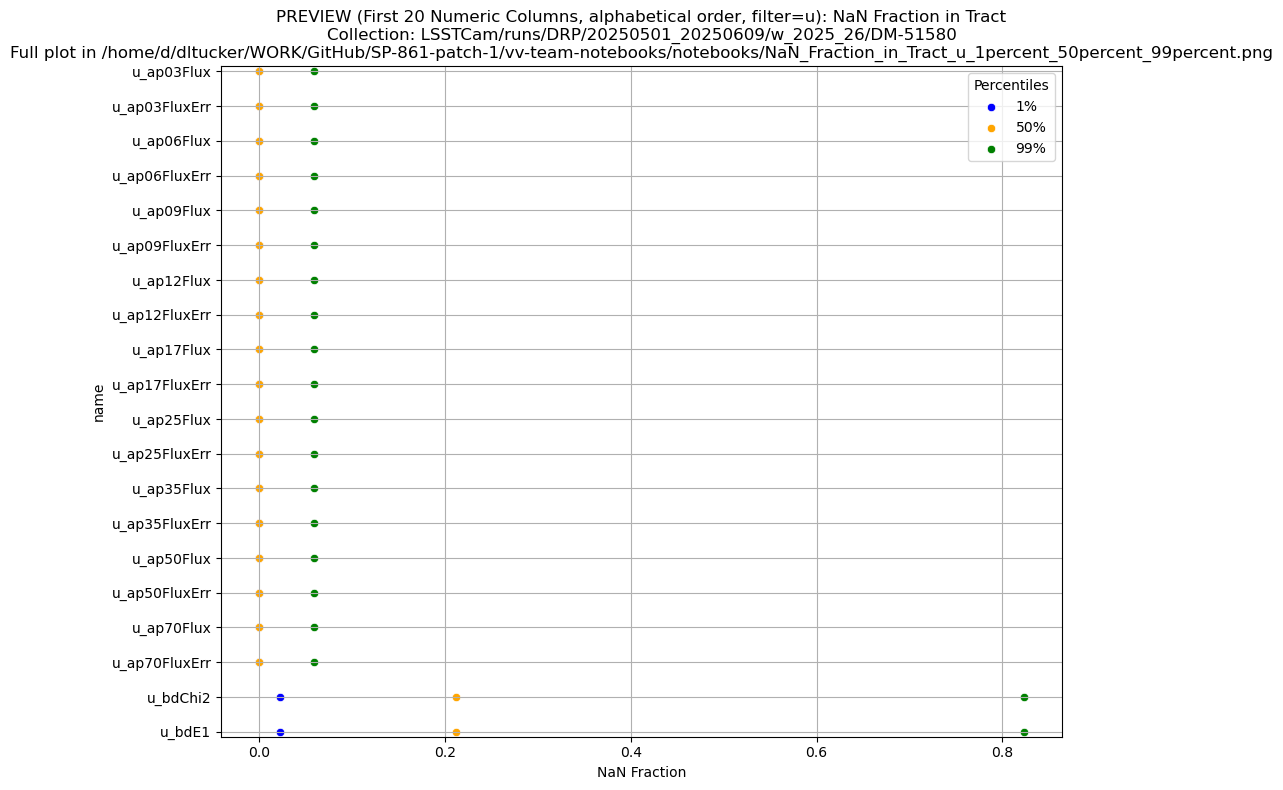

Generated preview plot with 20 rows (numeric columns) → displayed inline
Generated plot with 134 rows (numeric columns) → saved to: /home/d/dltucker/WORK/GitHub/SP-861-patch-1/vv-team-notebooks/notebooks/NaN_Fraction_in_Tract_g_1percent_50percent_99percent.png
Saved Summary plot for filter 'g' to: /home/d/dltucker/WORK/GitHub/SP-861-patch-1/vv-team-notebooks/notebooks/NaN_Fraction_in_Tract_g_1percent_50percent_99percent.png


In [ ]:

## 3.6 Plot the summary dataframe (split by filter only for objectTable)
## (ignoring tract+filter combinations that are all-NaN, except for the special *_psfModel_TwoGaussian_n_iter and 8_inputCountscolumns)

# Prepare DataFrame
df = summary_res_nan_fraction.copy()
df['name'] = df.index.str.replace('_nan_fraction', '', regex=False)

# Define filter groups only if objectTable
if table_type == 'objectTable':
    filternames = ['u', 'g', 'r', 'i', 'z', 'y', 'none']
    #filternames = ['g']   # <-- for testing a single filter
else:
    filternames = ['all']

# Plot Preview flag
plot_preview = True

# Loop over filternames...
for f in filternames:
    if f in ('none','all'):
        mask = ~df['name'].str.match(r'^[ugrizy]_')
    else:
        mask = df['name'].str.startswith(f"{f}_")

    df_subset = df.loc[mask].copy()
    if df_subset.empty:
        continue

    # --- CLEANING STEP drop all-NaN tract+filter combos (ignoring special cols)---
    if table_type == 'objectTable' and f not in ('none','all'):
        filter_cols = [c for c in res_nan_fraction.columns if c.startswith(f"{f}_")]
        special_cols = [f"{f}_psfModel_TwoGaussian_n_iter", f"{f}_inputCount"]
        for sc in special_cols:
            if sc in filter_cols:
                filter_cols.remove(sc)
        if filter_cols:
            mask_all_nan = res_nan_fraction[filter_cols].isna().all(axis=1)
            valid_tracts = res_nan_fraction.loc[~mask_all_nan, 'tract']
            # Keep only rows in df_subset corresponding to valid tracts
            # (summary_res_nan_fraction is column-oriented, so this step ensures
            # we only keep columns relevant to valid tracts)
            # If you only need to drop filters with no valid tracts, you can skip this
            df_subset = df_subset.loc[df_subset.index.isin([col for col in df_subset.index if any(col.startswith(f"{f}_") for f in [f])])]    
    
    if df_subset.empty:
        continue

    # Build output filename
    if table_type == 'objectTable':
        outputPlotFile = f'NaN_Fraction_in_Tract_{f}_1percent_50percent_99percent.png'
        superTitle = (
            f"'NaN Fraction in Tract' for ObjectTable Columns (filter={f})\n"
            f"Collection: {collectionName}"
        )
    elif table_type == 'sourceTable':
        outputPlotFile = 'NaN_Fraction_in_Visit_1percent_50percent_99percent.png'
        superTitle = (
            "'NaN Fraction in Visit' for SourceTable Columns\n"
            f"Collection: {collectionName}"
        )
    else:
        outputPlotFile = 'NaN_Fraction_1percent_50percent_99percent.png'
        superTitle = f"'NaN Fraction' Columns\nCollection: {collectionName}"

    #Full plot (save to file)
    plot_nan_fraction_summary(
        df=df_subset,
        table_type=table_type,
        collectionName=collectionName,
        output_file=outputPlotFile,
        show_inline=False,
        title_prefix="",
        max_height_per_row=0.25,
        base_height=4
    )
    print(f"Saved Summary plot for filter '{f}' to: {os.path.abspath(outputPlotFile)}")

    # Only plot preview for the first (or only) filtername...
    if plot_preview:    
        # Preview: always top 20 rows of this subset inline
        plot_nan_fraction_summary(
            df=df_subset.head(20),
            table_type=table_type,
            collectionName=collectionName,
            output_file=None,
            show_inline=True,
            title_prefix=f"PREVIEW (First 20 Numeric Columns, alphabetical order, filter={f}):",
            max_height_per_row=0.4,
            base_height=4,
            full_plot_path=outputPlotFile
        )
        plot_preview = False


In [ ]:

## 4.0 Clean up

#Reset pandas to its default maximum rows to print to screen
pd.reset_option("display.max_rows")

In [ ]:
raise StopExecution()

## SandBox